# Miner√≠a de Datos sobre Capa Oro

Este notebook desarrolla un an√°lisis completo de **miner√≠a de datos** sobre informaci√≥n meteorol√≥gica de la provincia de Misiones.

### Objetivos
1. **Generar y explorar la variable `LLUEVE`** para identificar d√≠as lluviosos.
2. **Descubrir patrones y relaciones ocultas** mediante visualizaci√≥n, combinaciones y clustering.
3. **Cubrir las etapas de miner√≠a de datos** dentro del flujo **CRISP-DM**:
   - Comprensi√≥n de los datos
   - Preparaci√≥n
   - Miner√≠a / Modelado
   - Evaluaci√≥n

El enfoque es **no supervisado**, buscando patrones sin usar etiquetas predefinidas.

# Importar las librer√≠as necesarias

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from mlxtend.frequent_patterns import apriori, association_rules
import warnings

# Deshabilitar warnings futuros
warnings.simplefilter(action='ignore', category=FutureWarning)

MINERIA_DIR = Path('../data/mineria')
MINERIA_DIR.mkdir(parents=True, exist_ok=True)

print("Importaci√≥n de librer√≠as completada.")

Importaci√≥n de librer√≠as completada.


## Carga de datos

Se cargan los datasets generados en la **Capa Oro**:
- `dataset_oro_diario.csv` ‚Üí Datos diarios por estaci√≥n.
- `dataset_oro_horario.csv` ‚Üí Datos horarios por estaci√≥n.

In [2]:
# Carga de datasets Oro
file_diario = '../data/oro/dataset_oro_diario.csv'
file_horario = '../data/oro/dataset_oro_horario.csv'

df_diario = pd.read_csv(file_diario)
df_horario = pd.read_csv(file_horario)

print("Dimensiones datos diarios:", df_diario.shape)
print("Dimensiones datos horarios:", df_horario.shape)

df_diario.head()

Dimensiones datos diarios: (852, 25)
Dimensiones datos horarios: (20448, 10)


ESTACION       FECHA  TEMP_MEAN  TEMP_MIN  TEMP_MAX  PNM_MEAN  \
0  CHAPELCO AERO  2024-06-01        4.1         2         7    1014.6   
1  CHAPELCO AERO  2024-06-02        1.2        -2         5    1026.2   
2  CHAPELCO AERO  2024-06-03        2.8        -2         5    1020.9   
3  CHAPELCO AERO  2024-06-04        4.2        -1        12    1014.5   
4  CHAPELCO AERO  2024-06-05        6.9         5         9    1009.8   

   PNM_MIN  PNM_MAX  HUM_MEAN  HUM_MIN  ...  WIND_SPEED_MIN  WIND_SPEED_MAX  \
0     1012     1018      76.4       51  ...               0              39   
1     1019     1030      83.1       57  ...               0              22   
2     1017     1029      65.5       52  ...               0              22   
3     1012     1017      84.8       63  ...               0              11   
4     1008     1012      96.5       94  ...               0              11   

   TEMP_MEAN_NORM  PNM_MEAN_NORM  HUM_MEAN_NORM  WIND_DIR_MEAN_NORM  \
0         0.20643        0.41346        0.72142             0.59074   
1         0.12869        0.69231        0.80946             0.30339   
2         0.17158        0.56490        0.57819             0.19089   
3         0.20912        0.41106        0.83180             0.08908   
4         0.28150        0.29808        0.98555             0.36905   

   WIND_SPEED_MEAN_NORM  AMP_TERMICA  RANGO_PRESION  RANGO_HUMEDAD  
0               0.65969            5              6             42  
1               0.23037            7             11             42  
2               0.35864            7             12             42  
3               0.06021           13              5             35  
4               0.10995            4              4              6  

[5 rows x 25 columns]

## Generaci√≥n de la variable `LLUEVE`

Como no contamos con precipitaci√≥n directa, se define la lluvia mediante la regla heur√≠stica:

- **1 (Llueve)** si `Humedad > 75%` y `Presi√≥n < 1010 hPa`  
- **0 (No llueve)** en caso contrario

Esto permite contar con una etiqueta binaria para miner√≠a de datos.

In [3]:
# Crear variables binarias de lluvia

# Condici√≥n: humedad > 75% y presi√≥n < 1010 hPa
humedad = 75
presion = 1010

df_diario['LLUEVE'] = ((df_diario['HUM_MEAN'] > humedad) & 
                       (df_diario['PNM_MEAN'] < presion)).astype(int)

df_horario['LLUEVE'] = ((df_horario['HUM'] > humedad) & 
                        (df_horario['PNM'] < presion)).astype(int)

print("Variables generadas")
print("")
print("Distribuci√≥n LLUEVE (0=No,1=S√≠):")
print("")
print(df_diario['LLUEVE'].value_counts())

df_diario[['ESTACION','FECHA','HUM_MEAN','PNM_MEAN','LLUEVE']].head(10)

Variables generadas

Distribuci√≥n LLUEVE (0=No,1=S√≠):

LLUEVE
0    823
1     29
Name: count, dtype: int64


ESTACION       FECHA  HUM_MEAN  PNM_MEAN  LLUEVE
0  CHAPELCO AERO  2024-06-01      76.4    1014.6       0
1  CHAPELCO AERO  2024-06-02      83.1    1026.2       0
2  CHAPELCO AERO  2024-06-03      65.5    1020.9       0
3  CHAPELCO AERO  2024-06-04      84.8    1014.5       0
4  CHAPELCO AERO  2024-06-05      96.5    1009.8       1
5  CHAPELCO AERO  2024-06-06      97.6    1013.6       0
6  CHAPELCO AERO  2024-06-07      94.0    1016.5       0
7  CHAPELCO AERO  2024-06-08      94.8    1007.4       1
8  CHAPELCO AERO  2024-06-09      88.0    1009.4       1
9  CHAPELCO AERO  2024-06-10      92.8    1011.1       0

# Guardar el dataset con las variables generadas

In [4]:
# Guardar los datasets con la nueva variable. Exportaci√≥n a CSV
df_diario.to_csv(MINERIA_DIR / 'dataset_mineria_diario.csv', index=False)
df_horario.to_csv(MINERIA_DIR / 'dataset_mineria_horario.csv', index=False)

print("Archivos generados con la variable LLUEVE.")
print(f"Filas diarias: {len(df_diario)} | Filas horarias: {len(df_horario)}")
print("Muestra de datos con la variable LLUEVE (diario):")
print(df_diario[['ESTACION','FECHA','HUM_MEAN','PNM_MEAN','LLUEVE']].head())

Archivos generados con la variable LLUEVE.
Filas diarias: 852 | Filas horarias: 20448
Muestra de datos con la variable LLUEVE (diario):
        ESTACION       FECHA  HUM_MEAN  PNM_MEAN  LLUEVE
0  CHAPELCO AERO  2024-06-01      76.4    1014.6       0
1  CHAPELCO AERO  2024-06-02      83.1    1026.2       0
2  CHAPELCO AERO  2024-06-03      65.5    1020.9       0
3  CHAPELCO AERO  2024-06-04      84.8    1014.5       0
4  CHAPELCO AERO  2024-06-05      96.5    1009.8       1


## Exploraci√≥n y visualizaci√≥n de la variable `LLUEVE`

Se analiza la distribuci√≥n de d√≠as con lluvia, por estaci√≥n y de manera temporal.
Adem√°s, se incluye un **heatmap de correlaci√≥n** para detectar **relaciones ocultas** entre variables.

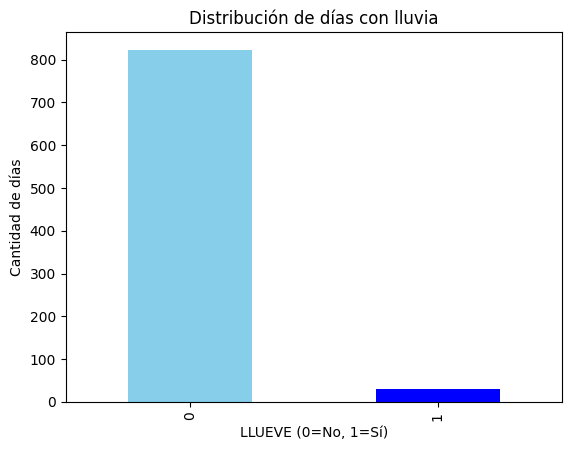

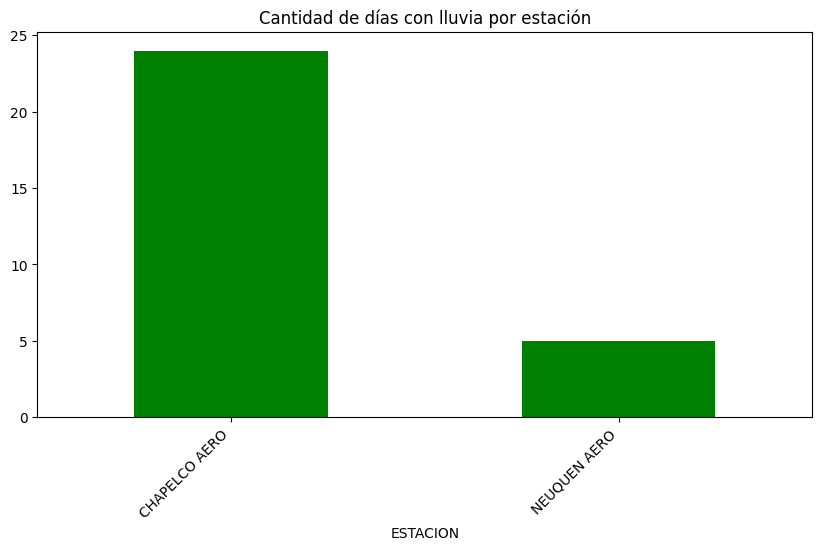

In [5]:
# Conteo lluvia
df_diario['LLUEVE'].value_counts().plot(kind='bar', color=['skyblue','blue'])
plt.title("Distribuci√≥n de d√≠as con lluvia")
plt.xlabel("LLUEVE (0=No, 1=S√≠)")
plt.ylabel("Cantidad de d√≠as")
plt.show()

# Lluvia por estaci√≥n
df_diario.groupby('ESTACION')['LLUEVE'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5), color='green')
plt.title("Cantidad de d√≠as con lluvia por estaci√≥n")
plt.xticks(rotation=45, ha='right')
plt.show()

### Heatmap de correlaci√≥n general

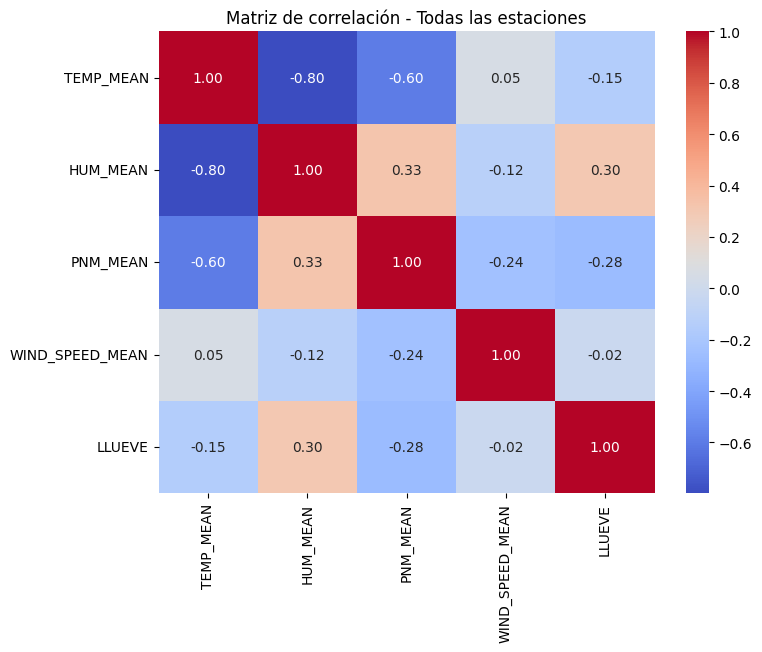

In [6]:

vars_corr = ['TEMP_MEAN','HUM_MEAN','PNM_MEAN','WIND_SPEED_MEAN','LLUEVE']

plt.figure(figsize=(8,6))
sns.heatmap(df_diario[vars_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlaci√≥n - Todas las estaciones")
plt.show()



### Generar un heatmap por cada estaci√≥n

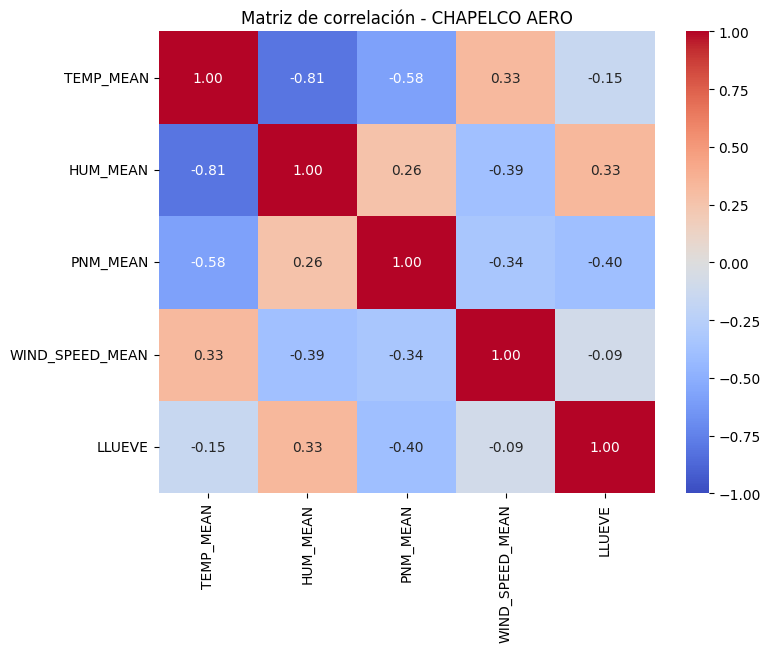

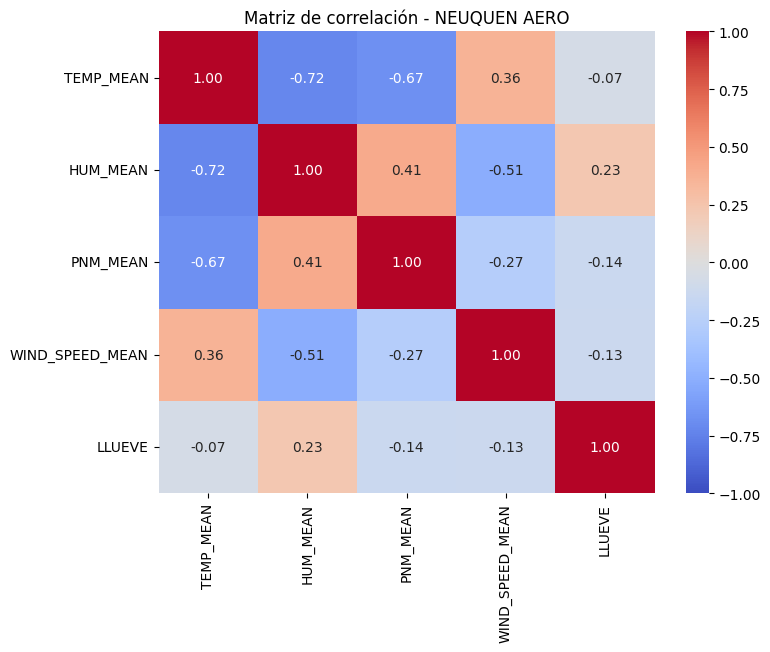

In [7]:
for estacion in df_diario['ESTACION'].unique():
    df_est = df_diario[df_diario['ESTACION'] == estacion]
    
    plt.figure(figsize=(8,6))
    sns.heatmap(df_est[vars_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Matriz de correlaci√≥n - {estacion}")
    plt.show()


## Combinaciones de condiciones clim√°ticas

Debido a que la lluvia es muy poco frecuente, **Apriori** no genera reglas √∫tiles.
Se opta por un an√°lisis de **combinaciones discretizadas** para estimar la probabilidad de lluvia por tipo de d√≠a.

1. **Discretizaci√≥n**:
   - `TEMP_MEAN` ‚Üí Fr√≠o / C√°lido
   - `HUM_MEAN` ‚Üí Baja / Alta
   - `PNM_MEAN` ‚Üí Baja / Alta
2. **Agrupaci√≥n** por combinaci√≥n y c√°lculo de:
   - D√≠as totales
   - D√≠as con lluvia
   - Porcentaje de lluvia


In [8]:
# Discretizaci√≥n en 2 categor√≠as
df_assoc = df_diario[['TEMP_MEAN','HUM_MEAN','PNM_MEAN','LLUEVE']].copy()
df_assoc['TEMP_CAT'] = pd.cut(df_assoc['TEMP_MEAN'], bins=[-5,20,50], labels=['Frio','Calido'])
df_assoc['HUM_CAT'] = pd.cut(df_assoc['HUM_MEAN'], bins=[0,85,100], labels=['Baja','Alta'])
df_assoc['PNM_CAT'] = pd.cut(df_assoc['PNM_MEAN'], bins=[950,1010,1050], labels=['Baja','Alta'])

# Agrupaci√≥n
df_grouped = df_assoc.groupby(['TEMP_CAT','HUM_CAT','PNM_CAT']).agg(
    dias_total=('LLUEVE','count'),
    dias_lluvia=('LLUEVE','sum')
).reset_index()

df_grouped['porcentaje_lluvia'] = (df_grouped['dias_lluvia'] / df_grouped['dias_total'] * 100).round(2)

df_grouped.sort_values('porcentaje_lluvia', ascending=False)

TEMP_CAT HUM_CAT PNM_CAT  dias_total  dias_lluvia  porcentaje_lluvia
2     Frio    Alta    Baja          17           17              100.0
0     Frio    Baja    Baja          71           12               16.9
1     Frio    Baja    Alta         579            0                0.0
3     Frio    Alta    Alta          44            0                0.0
4   Calido    Baja    Baja          67            0                0.0
5   Calido    Baja    Alta          74            0                0.0
6   Calido    Alta    Baja           0            0                NaN
7   Calido    Alta    Alta           0            0                NaN

## Clustering de d√≠as meteorol√≥gicos

Se aplica **K-Means** para agrupar d√≠as seg√∫n sus condiciones meteorol√≥gicas:

- Variables: `TEMP_MEAN`, `HUM_MEAN`, `PNM_MEAN`, `WIND_SPEED_MEAN`
- Escalado previo para que todas tengan igual peso
- **PCA** para visualizar los clusters en 2D

Cada color representa un **tipo de d√≠a**:
- C√°lido-Seco
- Fr√≠o-H√∫medo
- Intermedio

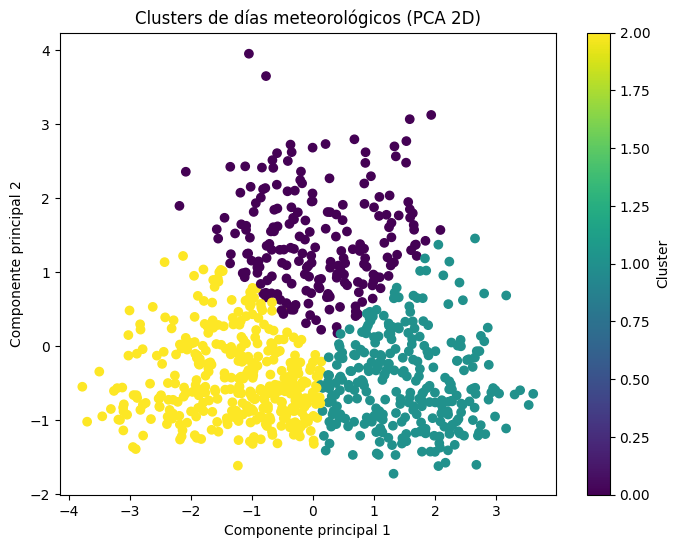

Contribuci√≥n de cada variable a los componentes principales:


PC1       PC2
TEMP_MEAN        0.628684 -0.235220
HUM_MEAN        -0.567527  0.234377
PNM_MEAN        -0.498934 -0.225856
WIND_SPEED_MEAN  0.183668  0.915821

CLUSTER
0    0.068293
1    0.000000
2    0.041322
Name: LLUEVE, dtype: float64

In [9]:
# Variables num√©ricas
X_clust = df_diario[['TEMP_MEAN','HUM_MEAN','PNM_MEAN','WIND_SPEED_MEAN']]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_diario['CLUSTER'] = kmeans.fit_predict(X_scaled)

# PCA para visualizaci√≥n
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_diario['CLUSTER'], cmap='viridis')
plt.title("Clusters de d√≠as meteorol√≥gicos (PCA 2D)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Cluster')
plt.show()

# üîπ Interpretaci√≥n de componentes principales
pca_df = pd.DataFrame(pca.components_, columns=X_clust.columns, index=['PC1','PC2'])
print("Contribuci√≥n de cada variable a los componentes principales:")
display(pca_df.T)

# Probabilidad de lluvia por cluster
df_diario.groupby('CLUSTER')['LLUEVE'].mean()

### Interpretaci√≥n del PCA con Clustering

En el gr√°fico PCA 2D:

- **Eje X (Componente Principal 1)**: 
  - Gradiente entre **d√≠as c√°lidos y secos** (derecha) y **d√≠as fr√≠os y h√∫medos** (izquierda).  
- **Eje Y (Componente Principal 2)**: 
  - Intensidad del **viento medio diario**.  
  - Arriba ‚Üí d√≠as ventosos | Abajo ‚Üí d√≠as calmos.

- **Colores de los puntos**: 
  - Cada color representa un **cluster identificado por K-Means**:  
    1. **Cluster 0 (amarillo/verde)** ‚Üí d√≠as c√°lidos y secos  
    2. **Cluster 1 (violeta/azul)** ‚Üí d√≠as fr√≠os y h√∫medos  
    3. **Cluster 2 (verde/azulado)** ‚Üí d√≠as intermedios

> Esta visualizaci√≥n permite entender **tipos de d√≠as** y su relaci√≥n con la lluvia.


## Visualizaci√≥n con t-SNE

El **t-SNE (t-Distributed Stochastic Neighbor Embedding)** es una t√©cnica de **reducci√≥n de dimensionalidad no lineal** utilizada principalmente para **visualizaci√≥n**.

- **Objetivo:** Representar datos de alta dimensi√≥n en 2D/3D preservando **vecindades locales**.
- **Ventaja:** Permite descubrir patrones o agrupamientos que **PCA lineal** podr√≠a no reflejar.
- **Limitaci√≥n:** 
  - Los ejes no tienen interpretaci√≥n f√≠sica como PCA. 
  - Solo importa la **proximidad de puntos**: puntos cercanos ‚Üí d√≠as meteorol√≥gicos similares.

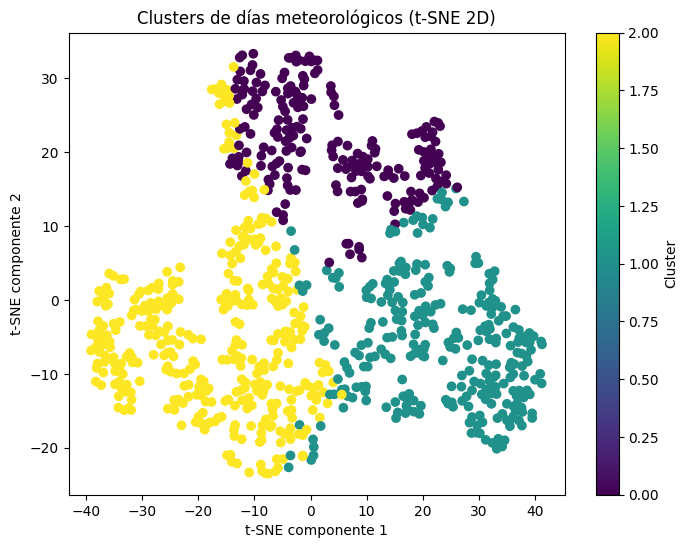

In [10]:
# t-SNE en 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Visualizaci√≥n de clusters en t-SNE
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_diario['CLUSTER'], cmap='viridis')
plt.title("Clusters de d√≠as meteorol√≥gicos (t-SNE 2D)")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.colorbar(label='Cluster')
plt.show()

### Interpretaci√≥n del gr√°fico t-SNE

- Cada **punto** = un **d√≠a meteorol√≥gico**.
- **Colores** = clusters asignados por K-Means (tipos de d√≠as).  
- **Proximidad** = similitud de condiciones:  
  - Puntos cercanos ‚Üí d√≠as con condiciones similares  
  - Puntos alejados ‚Üí d√≠as con comportamientos distintos  
- **Los ejes no representan variables meteorol√≥gicas directas**, solo una proyecci√≥n que facilita la visualizaci√≥n de grupos.

# Conclusi√≥n

En esta etapa se trabaj√≥ sobre los datos horarios procesados del SMN, aplicando t√©cnicas de **miner√≠a de datos y an√°lisis exploratorio** para descubrir patrones relacionados con la ocurrencia de lluvia.  
El objetivo principal fue **generar conocimiento a partir de los datos procesados**, preparando la informaci√≥n para etapas posteriores de clasificaci√≥n y modelado predictivo.

1. **Generaci√≥n de `LLUEVE`:**  
   - Se cre√≥ una etiqueta binaria que indica lluvia (1) o no lluvia (0), derivada de las condiciones meteorol√≥gicas.  
   - Se confirm√≥ un **dataset desbalanceado**, con pocas ocurrencias de la clase positiva.

2. **Exploraci√≥n y relaciones ocultas:**  
   - Los **heatmaps de correlaci√≥n** mostraron que la lluvia est√° fuertemente asociada a **humedad alta** y **presi√≥n baja**.  
   - Al analizar por estaci√≥n meteorol√≥gica, se observaron **patrones consistentes**.

3. **Combinaciones de condiciones:**  
   - Los d√≠as con **humedad alta y presi√≥n baja** alcanzan **m√°xima probabilidad de lluvia** en el hist√≥rico.  
   - Los **d√≠as c√°lidos y h√∫medos** son los m√°s propensos a eventos de lluvia.

4. **Clustering y reducci√≥n de dimensionalidad:**  
   - El algoritmo **K-Means** identific√≥ **3 tipos de d√≠as**: c√°lidos-secos, fr√≠os-h√∫medos e intermedios.  
   - La **PCA 2D** permiti√≥ interpretar los ejes principales como:  
     - **PC1** ‚Üí Gradiente c√°lido vs. fr√≠o-h√∫medo  
     - **PC2** ‚Üí Intensidad del viento  
   - La t√©cnica **t-SNE** confirm√≥ la **separaci√≥n de clusters** y revel√≥ vecindades locales entre d√≠as con caracter√≠sticas similares.

Este an√°lisis de **miner√≠a de datos** permiti√≥ comprender la estructura y los patrones del dataset, dejando la informaci√≥n **lista para la siguiente etapa de clasificaci√≥n supervisada**, donde se evaluar√° la capacidad predictiva de distintos modelos sobre la variable `LLUEVE`.